<a href="https://colab.research.google.com/github/ryanreilly/phase_5_capstone/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
!unzip drive/MyDrive/train.zip
!unzip drive/MyDrive/dev.zip
!unzip drive/MyDrive/test.zip

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

In [4]:
train_dir = 'train'
validation_dir = 'dev'
test_dir = 'test'

In [5]:
#For manipulating and visualizing images
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

#To load an image using Keras
from tensorflow.keras.preprocessing.image import load_img, ImageDataGenerator
from tensorflow.keras.layers import Flatten, Dense, Dropout, Input, Conv2D, MaxPooling2D
from tensorflow.keras import optimizers, models, applications
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.models import Model

#To plot confusion matrix
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, classification_report 

#to track how long the models run
import datetime

#For dividing the images into correct folders
import shutil
import os

#To ignore warnings
import warnings
warnings.filterwarnings('ignore')

VGG16 Transfer Learning


In [6]:
# All images will be rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255, 
                                   rotation_range=30,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode='nearest')
            
validation_datagen = ImageDataGenerator(rescale=1./255)

In [7]:
train_generator_vgg = train_datagen.flow_from_directory(train_dir,
                                                    target_size=(224, 224),
                                                    batch_size=32,
                                                    class_mode='categorical')

validation_generator_vgg = validation_datagen.flow_from_directory(validation_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical')

Found 12422 images belonging to 7 classes.
Found 1458 images belonging to 7 classes.


In [8]:
vggmodel = VGG16(weights='imagenet', 
                 include_top=True)

vggmodel.trainable = False

# Define Model Architecture
X = vggmodel.layers[-2].output
X = Dropout(0.2)(X)
predictions = Dense(7, activation="softmax")(X)
model_final = Model(inputs = vggmodel.input, outputs = predictions)


for layer in vggmodel.layers:
    layer.trainable = False


opt = optimizers.Adam(learning_rate=0.001)
model_final.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])

checkpoint = ModelCheckpoint("vgg16_1.h5", 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False, 
                             mode='auto', 
                             period=1)

early = EarlyStopping(monitor='val_accuracy', 
                      min_delta=0, 
                      patience=4, 
                      verbose=1, 
                      mode='auto')

history_3 = model_final.fit_generator(generator= train_generator_vgg,
                                    #steps_per_epoch= 10, 
                                    epochs= 100, 
                                    validation_data= validation_generator_vgg, 
                                    validation_steps=1, 
                                    callbacks=[checkpoint,early])

553467904/553467096 [==============================] - 13s 0us/step
Epoch 1/100
389/389 [==============================] - 321s 778ms/step - loss: 1.5861 - accuracy: 0.4270 - val_loss: 1.4530 - val_accuracy: 0.4375

Epoch 00001: val_accuracy improved from -inf to 0.43750, saving model to vgg16_1.h5
Epoch 2/100
389/389 [==============================] - 305s 784ms/step - loss: 1.4464 - accuracy: 0.4784 - val_loss: 1.6982 - val_accuracy: 0.3125

Epoch 00002: val_accuracy did not improve from 0.43750
Epoch 3/100
389/389 [==============================] - 302s 777ms/step - loss: 1.4443 - accuracy: 0.4832 - val_loss: 1.2555 - val_accuracy: 0.5625

Epoch 00003: val_accuracy improved from 0.43750 to 0.56250, saving model to vgg16_1.h5
Epoch 4/100
389/389 [==============================] - 303s 780ms/step - loss: 1.3825 - accuracy: 0.5035 - val_loss: 1.7034 - val_accuracy: 0.4375

Epoch 00004: val_accuracy did not improve from 0.56250
Epoch 5/100
389/389 [==============================] - 305s

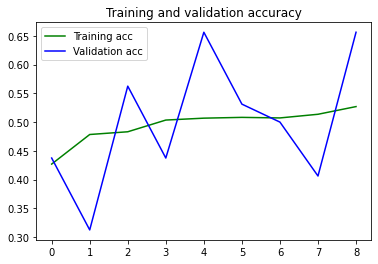

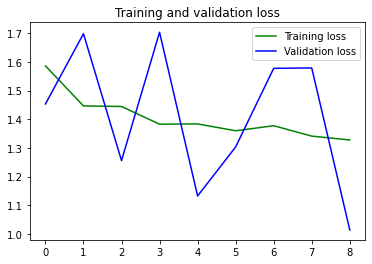

In [9]:
acc = history_3.history['accuracy']
val_acc = history_3.history['val_accuracy']
loss = history_3.history['loss']
val_loss = history_3.history['val_loss']
epochs = range(len(acc))


plt.plot(epochs, acc, 'g', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [10]:
test_datagen = ImageDataGenerator(rescale=1./255)

In [11]:
test_generator_vgg = test_datagen.flow_from_directory(test_dir, 
                                                              target_size=(224, 224), 
                                                              batch_size=32, 
                                                              class_mode='categorical')

Found 3147 images belonging to 7 classes.


In [12]:
y_pred = model_final.predict(test_generator_vgg, batch_size=32)

In [13]:
y_pred = np.argmax(y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(test_generator_vgg.classes, y_pred))

Confusion Matrix
[[ 54  28  19 131  26 128  18]
 [ 44  21   9  83  22  86  15]
 [ 97  35  28 213  40 174  12]
 [ 43  25  18 114  21 124   7]
 [ 24  20  11  68  14  80   3]
 [139  63  57 337  64 308  22]
 [ 43  23  18  94  24  93   7]]


In [14]:
print(classification_report(test_generator_vgg.classes, y_pred, target_names = [key for key,value in test_generator_vgg.class_indices.items()]))

                precision    recall  f1-score   support

    earthquake       0.12      0.13      0.13       404
          fire       0.10      0.07      0.08       280
         flood       0.17      0.05      0.07       599
     hurricane       0.11      0.32      0.16       352
     landslide       0.07      0.06      0.06       220
  not_disaster       0.31      0.31      0.31       990
other_disaster       0.08      0.02      0.04       302

      accuracy                           0.17      3147
     macro avg       0.14      0.14      0.12      3147
  weighted avg       0.18      0.17      0.16      3147

